In [22]:
!pip install git+https://gitlab-research.centralesupelec.fr/stergios.christodoulidis/text-flappy-bird-gym.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://gitlab-research.centralesupelec.fr/stergios.christodoulidis/text-flappy-bird-gym.git to /tmp/pip-req-build-_whbkfkq
  Running command git clone --filter=blob:none --quiet https://gitlab-research.centralesupelec.fr/stergios.christodoulidis/text-flappy-bird-gym.git /tmp/pip-req-build-_whbkfkq
  Resolved https://gitlab-research.centralesupelec.fr/stergios.christodoulidis/text-flappy-bird-gym.git to commit bdbddee93a6d59029989c32cc41748adb2724f51
  Preparing metadata (setup.py) ... done


In [23]:
import time
import random
import os, sys
import numpy as np
import gymnasium as gym
import text_flappy_bird_gym
from collections import deque, defaultdict

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import matplotlib.pyplot as plt
import matplotlib

is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

import warnings
warnings.filterwarnings('ignore')

# Distance agents

In [49]:
if __name__ == '__main__':

    # initiate environment
    env = gym.make('TextFlappyBird-v0', height = 15, width = 20, pipe_gap = 4)
    obs = env.reset()
    
    while True:

        # Select next action
        action = env.action_space.sample()  # for an agent, action = agent.policy(observation)
        # Appy action and return new observation of the environment
        obs, reward, done, _, info = env.step(action)

        # Render the game
        os.system('clear')
        sys.stdout.write(env.render())
        time.sleep(0.2) # FPS

        # If player is dead break
        if done:
            break

    env.close()

Text Flappy Bird!
Score: 0
----------------------
[                  | ]
[                  | ]
[                  | ]
[                  | ]
[                    ]
[                    ]
[                    ]
[      @             ]
[                  | ]
[                  | ]
[                  | ]
[                  | ]
[                  | ]
[                  | ]
[                  | ]
^^^^^^^^^^^^^^^^^^^^^^
Player Action (Idle)
Distance From Pipe (dx=12,dy=1)
Text Flappy Bird!
Score: 0
----------------------
[                 |  ]
[                 |  ]
[                 |  ]
[                 |  ]
[                    ]
[                    ]
[                    ]
[                    ]
[                 |  ]
[      @          |  ]
[                 |  ]
[                 |  ]
[                 |  ]
[                 |  ]
[                 |  ]
^^^^^^^^^^^^^^^^^^^^^^
Player Action (Idle)
Distance From Pipe (dx=11,dy=3)
Text Flappy Bird!
Score: 0
----------------------
[       

## Expected SARSA

In [50]:
class ExpectedSarsaAgent():
    def __init__(self, agent_init_info):
        self.alpha = agent_init_info['alpha']
        self.alpha_decay = agent_init_info['alpha_decay']
        self.gamma = agent_init_info['gamma']
        self.epsilon = agent_init_info['epsilon']
        self.eps_decay = agent_init_info['eps_decay']
        self.q_tables = defaultdict(lambda: np.zeros(2))
    
    def act(self, state):
        if np.random.random() < self.epsilon:
            current_action = env.action_space.sample()
        else:
            current_action = np.argmax(self.q_tables[state])
        return current_action
        
    def update(self, state, action, next_state, next_action, reward):
        current_q = self.q_tables[state][action]
        next_q = self.q_tables[next_state][next_action]
        self.q_tables[state][action] = current_q + self.alpha * (reward + self.gamma * next_q - current_q)
        
        # Decay for the epsilon
        if self.epsilon > 0.0001:
            self.epsilon = max(self.epsilon * self.eps_decay, 0.0001)
        # Decay for the step-size
        if self.alpha > 0.1:
            self.alpha = max(self.alpha * self.alpha_decay, 0.1)

In [68]:
agent_init_info = {'epsilon' : 0.07, 'alpha' : 0.4, 'gamma' : 0.9, 'eps_decay':	1.0, 'alpha_decay': 1.0}
num_episodes = 25000
reward_sum = []

start = time.time()
agent_esarsa = ExpectedSarsaAgent(agent_init_info)
for i in range(num_episodes):
    state, info = env.reset()
    done = False
    total_reward = 0
    while not done:
        action = agent_esarsa.act(state)
        next_state, reward, done, _, info = env.step(action)
        next_action = agent_esarsa.act(next_state)
        if done == True:
            reward = -1
        total_reward += reward
        agent_esarsa.update(state, action, next_state, next_action, reward)
        state = next_state
        if done:
            break
    if (i+1)%5000 == 0:
        print(f'Episode {i+1}')
    reward_sum.append(total_reward)
    env.close()
print(f'The mean cumulative reward obtained by the Expected SARSA agent: {np.mean(reward_sum)}\nExecution time: {np.round(time.time() - start, 2)}')

Episode 5000
Episode 10000
Episode 15000
Episode 20000
Episode 25000
The mean cumulative reward obtained by the Expected SARSA agent: 105.0244
Execution time: 82.54


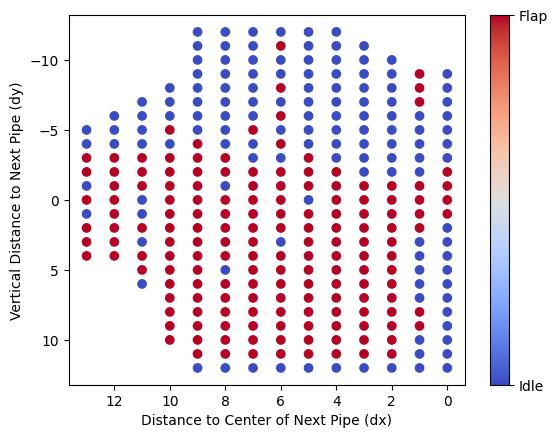

In [69]:
x_coords = [dx for dx, dy in list(agent_esarsa.q_tables.keys())]
y_coords = [dy for dx, dy in list(agent_esarsa.q_tables.keys())]
colors = [np.argmax(agent_esarsa.q_tables[(dx, dy)]) for dx, dy in list(agent_esarsa.q_tables.keys())]

scatter = plt.scatter(x_coords, y_coords, c=colors, cmap='coolwarm')

plt.xlabel('Distance to Center of Next Pipe (dx)')
plt.ylabel('Vertical Distance to Next Pipe (dy)')
plt.gca().invert_yaxis()
plt.gca().invert_xaxis()
cbar = plt.colorbar(scatter, ticks=[0, 1])
cbar.ax.set_yticklabels(['Idle', 'Flap'])
plt.show()

## Q-learning

In [74]:
class QLearningAgent():
    def __init__(self, agent_init_info):
        self.alpha = agent_init_info['alpha']
        self.alpha_decay = agent_init_info['alpha_decay']
        self.gamma = agent_init_info['gamma']
        self.epsilon = agent_init_info['epsilon']
        self.eps_decay = agent_init_info['eps_decay']
        self.q_tables = defaultdict(lambda: np.zeros(2))
    
    def act(self, state):
        if np.random.random() < self.epsilon:
            current_action = env.action_space.sample()
        else:
            current_action = np.argmax(self.q_tables[state])
        return current_action
        
    def update(self, state, action, next_state, next_action, reward):
        old_q = self.q_tables[state][action]
        next_max = np.max(self.q_tables[next_state])
        self.q_tables[state][action] = (1 - self.alpha) * old_q + self.alpha * (reward + self.gamma * next_max)
        
        # Decay for the epsilon
        if self.epsilon > 0.0001:
            self.epsilon = max(self.epsilon * self.eps_decay, 0.0001)
        # Decay for the step-size
        if self.alpha > 0.1:
            self.alpha = max(self.alpha * self.alpha_decay, 0.1)

In [76]:
agent_init_info = {'epsilon' : 0.05, 'alpha' : 0.75, 'gamma' : 1.0, 'eps_decay':	0.99999, 'alpha_decay': 0.99999}
num_episodes = 25000
reward_sum = []

start = time.time()
agent_qlearning = QLearningAgent(agent_init_info)
for i in range(num_episodes):
    state, info = env.reset()
    done = False
    total_reward = 0
    while not done:
        action = agent_qlearning.act(state)
        next_state, reward, done, _, info = env.step(action)
        next_action = agent_qlearning.act(next_state)
        if done == True:
            reward = -1
        total_reward += reward
        agent_qlearning.update(state, action, next_state, next_action, reward)
        state = next_state
        if done:
            break
    if (i+1)%5000 == 0:
        print(f'Episode {i+1}')
    reward_sum.append(total_reward)
    env.close()
print(f'The mean cumulative reward obtained by the Q-learning agent: {np.mean(reward_sum)}\nExecution time: {np.round(time.time() - start, 2)}')

Episode 5000
Episode 10000
Episode 15000
Episode 20000
Episode 25000
The mean cumulative reward obtained by the Q-learning agent: 674.56352
Execution time: 659.09


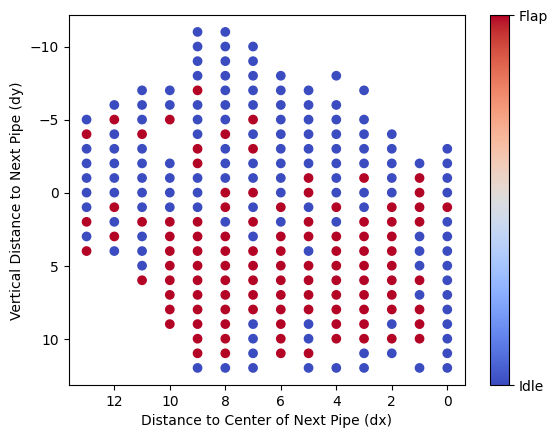

In [73]:
x_coords = [dx for dx, dy in list(agent_qlearning.q_tables.keys())]
y_coords = [dy for dx, dy in list(agent_qlearning.q_tables.keys())]
colors = [np.argmax(agent_qlearning.q_tables[(dx, dy)]) for dx, dy in list(agent_qlearning.q_tables.keys())]

scatter = plt.scatter(x_coords, y_coords, c=colors, cmap='coolwarm')

plt.xlabel('Distance to Center of Next Pipe (dx)')
plt.ylabel('Vertical Distance to Next Pipe (dy)')
plt.gca().invert_yaxis()
plt.gca().invert_xaxis()
cbar = plt.colorbar(scatter, ticks=[0, 1])
cbar.ax.set_yticklabels(['Idle', 'Flap'])
plt.show()

# Screen agent: DQN exploration

In [44]:
if __name__ == '__main__':

    # initiate environment
    env = gym.make('TextFlappyBird-screen-v0', height=15, width=20, pipe_gap=4)
    obs = env.reset()

    # iterate
    while True:

        # Select next action
        action = env.action_space.sample()  # for an agent, action = agent.policy(observation)
        # Appy action and return new observation of the environment
        obs, reward, done, _, info = env.step(action)

        # Render the game
        os.system('clear')
        sys.stdout.write(env.render())
        time.sleep(0.2) # FPS

        # If player is dead break

        print(obs.shape)
        if done:
            break

    env.close()

Text Flappy Bird!
Score: 0
----------------------
[                  | ]
[                  | ]
[                  | ]
[                  | ]
[                  | ]
[                  | ]
[                  | ]
[      @             ]
[                    ]
[                    ]
[                    ]
[                  | ]
[                  | ]
[                  | ]
[                  | ]
^^^^^^^^^^^^^^^^^^^^^^
(Idle)
(20, 15)
Text Flappy Bird!
Score: 0
----------------------
[                 |  ]
[                 |  ]
[                 |  ]
[                 |  ]
[                 |  ]
[                 |  ]
[                 |  ]
[                    ]
[                    ]
[      @             ]
[                    ]
[                 |  ]
[                 |  ]
[                 |  ]
[                 |  ]
^^^^^^^^^^^^^^^^^^^^^^
(Idle)
(20, 15)
Text Flappy Bird!
Score: 0
----------------------
[                |   ]
[                |   ]
[                |   ]
[            

In [45]:
class DQNConv(nn.Module):
    def __init__(self, action_size):
        super(DQNConv, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(32 * 5 * 3, 64)
        self.fc2 = nn.Linear(64, action_size)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = x.view(-1, 32 * 5 * 3)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [46]:
def plot_durations(scores, show_result=False):
    plt.figure(1)
    durations_t = torch.tensor(scores, dtype=torch.float)
    if show_result:
        plt.title('Result')
    else:
        plt.clf()
        plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())

In [47]:
class DQNAgent():
    def __init__(self, action_size, device, ckpt_path=None, gamma=0.95, epsilon=0.1, epsilon_min=0.01, epsilon_decay=0.995, lr=0.0001):
        self.action_size = action_size
        self.gamma = gamma
        self.epsilon = epsilon
        self.device = device
        self.lr = lr
        self.memory = deque(maxlen=10000)
        self.model = DQNConv(action_size).to(device)
        if ckpt_path is not None:
            self.model.load_state_dict(torch.load(ckpt_path))
        self.optimizer = torch.optim.AdamW(self.model.parameters(), lr=self.lr, amsgrad=True)
    
    def remember(self, state, action, reward, next_state):
        self.memory.append((state, action, reward, next_state))
        
    def act(self, state):
        explore = np.random.rand()
        # print(f'\n{explore}')
        if explore <= self.epsilon:
            # print('Exploration')
            return np.random.choice(self.action_size)
        # print('Exploitation')
        q_values = self.model(state)
        # print(f'Q-values: {q_values}')
        return torch.argmax(q_values[0]).item()

    def act_greedily(self, state):
        q_values = self.model(state)
        return torch.argmax(q_values[0]).item()
    
    def replay(self, batch_size):
        if len(self.memory) < batch_size:
            return
        batch = random.sample(self.memory, batch_size)

        # Compute a mask of non-final states and concatenate the batch elements
        non_final_mask = torch.tensor(tuple(map(lambda s: s[3] is not None, batch)), device=self.device, dtype=torch.bool)
        non_final_next_states = torch.cat([s[3] for s in batch if s[3] is not None])
        state_batch = torch.cat([s[0] for s in batch])
        action_batch = torch.tensor([s[1] for s in batch], device=self.device)
        reward_batch = torch.tensor([s[2] for s in batch], device=self.device)

        q_values = self.model(state_batch).gather(1, action_batch.unsqueeze(1))
        next_state_values = torch.zeros(len(batch), device=self.device)
        with torch.no_grad():
            next_state_values[non_final_mask] = self.model(non_final_next_states).max(1)[0]
        # Compute the expected Q values
        expected_q_values = (next_state_values * self.gamma) + reward_batch

        # Compute Huber loss
        criterion = nn.SmoothL1Loss()
        loss = criterion(q_values, expected_q_values.unsqueeze(1))
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

In [48]:
# Get number of actions from gym action space
action_size = env.action_space.n
# Get the number of state observations
state, info = env.reset()
height, width = state.shape

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
agent_dqn = DQNAgent(action_size, device, ckpt_path='/content/ckpt_dql_tfb.pth')

batch_size = 128
num_episodes = 50 # The checkpoint agent has been trained for 5000 but it would take to long.
scores_list = []

for episode in range(num_episodes):
    # print(f'\n========== Episode {episode} ==========')
    state, info = env.reset()
    state = np.reshape(state, [1, 1, height, width])
    state = torch.tensor(state, device=device, dtype=torch.float32)
    done = False
    score = 0

    while not done:
        action = agent_dqn.act(state)
        next_state, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated
        reward = reward if not done else -1
        # print(f'----- New action {action} -----\nDone? {done}\nReward for this action: {reward}')
        
        if terminated:
            next_state = None
        else:
            next_state = np.reshape(next_state, [1, 1, height, width])
            next_state = torch.tensor(next_state, device=device, dtype=torch.float32)

        agent_dqn.remember(state, action, reward, next_state)
        state = next_state
        score += 1
        
        if done:
            scores_list.append(score)
            # plot_durations(scores_list)
            break

        # print(f'\n========== Starting the optimization ==========\n')
        agent_dqn.replay(batch_size)
        # print('\n===============================================\n')

        # if episode % 200 == 0:
            # print(f'episode: {episode}/{num_episodes}, score: {score}')
            # torch.save(agent_dqn.model.state_dict(), f'checkpoint_{episode}.pth')
print(f'The mean cumulative reward obtained by the DQN agent: {np.mean(scores_list)}')

The mean cumulative reward obtained by the DQN agent: 20.86


In [33]:
obs, info = env.reset()

while True:
    obs = np.reshape(obs, [1, 1, 20, 15])
    obs = torch.tensor(obs, device=device, dtype=torch.float32)
    # Select next action
    action = agent_dqn.act(obs)
    # Appy action and return new observation of the environment
    obs, reward, done, _, info = env.step(action)

    # Render the game
    os.system('clear')
    sys.stdout.write(env.render())
    time.sleep(0.2) # FPS

    # If player is dead break

    print(obs.shape)
    if done:
        break

env.close()

Text Flappy Bird!
Score: 0
----------------------
[                  | ]
[                  | ]
[                  | ]
[                  | ]
[                  | ]
[                    ]
[                    ]
[      @             ]
[                    ]
[                  | ]
[                  | ]
[                  | ]
[                  | ]
[                  | ]
[                  | ]
^^^^^^^^^^^^^^^^^^^^^^
(Idle)
(20, 15)
Text Flappy Bird!
Score: 0
----------------------
[                 |  ]
[                 |  ]
[                 |  ]
[                 |  ]
[                 |  ]
[                    ]
[                    ]
[                    ]
[                    ]
[      @          |  ]
[                 |  ]
[                 |  ]
[                 |  ]
[                 |  ]
[                 |  ]
^^^^^^^^^^^^^^^^^^^^^^
(Idle)
(20, 15)
Text Flappy Bird!
Score: 0
----------------------
[                |   ]
[                |   ]
[                |   ]
[            